# Demo of PyMC models

In [1]:
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt

In [2]:
%config InlineBackend.figure_format = 'svg'
az.style.use("arviz-darkgrid")

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
export_images = True

## Synthetic Control

In [5]:
# # Generate data
# from causalpy.simulate_data import generate_synthetic_control_data

# treatment_time = 70
# df, weightings_true = generate_synthetic_control_data(treatment_time=treatment_time)
# df.to_csv("../causalpy/data/synthetic_control.csv", index=False)

In [6]:
# Load data
df = pd.read_csv('../causalpy/data/synthetic_control.csv')
treatment_time = 70

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6612, but should be close to 0.8. Try to increase the number of tuning steps.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.886, but should be close to 0.8. Try to increase the number of tuning steps.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


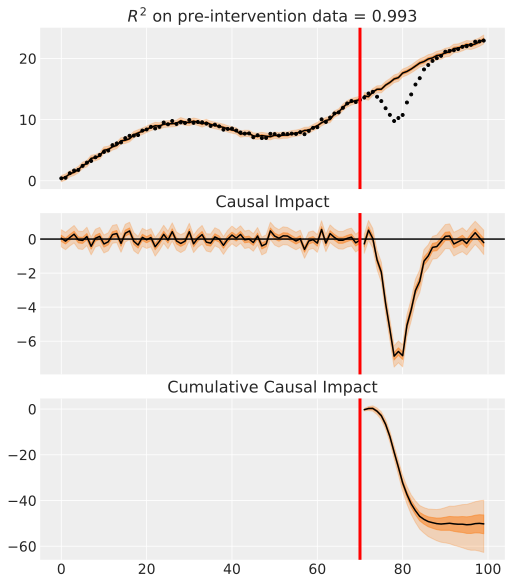

In [7]:
from causalpy.pymc_experiments import SyntheticControl
from causalpy.pymc_models import WeightedSumFitter

# Note, we do not want an intercept in this model
thing = SyntheticControl(df,
                         treatment_time,
                         formula = "actual ~ 0 + a + b + c + d + e + f + g",
                         prediction_model=WeightedSumFitter())

thing.plot();

if export_images:
    plt.savefig('../img/synthetic_control_pymc.svg', bbox_inches='tight', format="svg")

## Interrupted time series

In [8]:
# # Generate data
# from causalpy.simulate_data import generate_time_series_data

# df = generate_time_series_data("2017-01-01")
# df = df.loc[:, ['month', 'year', 't', 'y']]
# df.to_csv("../causalpy/data/its.csv")

In [9]:
# Load data
df = pd.read_csv('../causalpy/data/its.csv', parse_dates=["date"])
df.set_index("date", inplace=True)
treatment_time = pd.to_datetime("2017-01-01")
df.head()

,month,year,t,y
date,,,,
2010-01-31,1,2010,0,25.058186
2010-02-28,2,2010,1,27.189812
2010-03-31,3,2010,2,26.487551
2010-04-30,4,2010,3,31.241716
2010-05-31,5,2010,4,40.753973


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


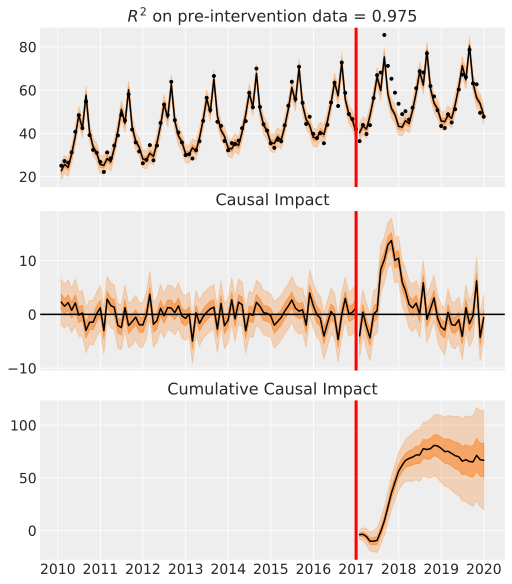

In [10]:
from causalpy.pymc_experiments import InterruptedTimeSeries
from causalpy.pymc_models import LinearRegression

thing = InterruptedTimeSeries(df, 
                              treatment_time, 
                              formula = 'y ~ 1 + t + C(month)', 
                              prediction_model=LinearRegression())

fig, ax = thing.plot()

if export_images:
    plt.savefig('../img/interrupted_time_series_pymc.svg', bbox_inches='tight', format="svg")

## Difference in differences

In [11]:
data = pd.read_csv("../causalpy/data/did.csv")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


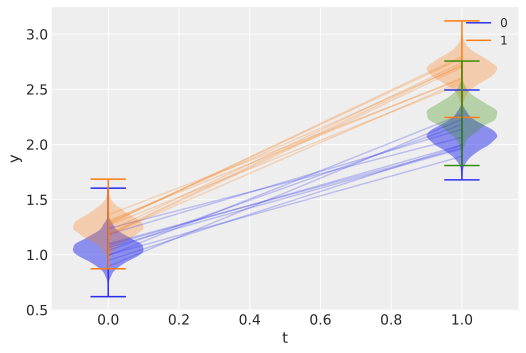

In [12]:
from causalpy.pymc_experiments import DifferenceInDifferences
from causalpy.pymc_models import LinearRegression

# NOTE: `treated` is a deterministic function of `t` and `group`. So add this function into the formula.

thing = DifferenceInDifferences(data, 
                                formula = 'y ~ 1 + group + t + treated:group',
                                prediction_model=LinearRegression())
fig, ax = thing.plot()

if export_images:
    plt.savefig('../img/difference_in_differences_pymc.svg', bbox_inches='tight', format="svg")

## Regression discontinuity

In [13]:
# # Generate data
# from causalpy.simulate_data import generate_regression_discontinuity_data
# df = generate_regression_discontinuity_data(true_treatment_threshold=0.5)
# df.to_csv('../causalpy/data/regression_discontinuity.csv', index=False)

In [14]:
# Load data
data = pd.read_csv('../causalpy/data/regression_discontinuity.csv')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


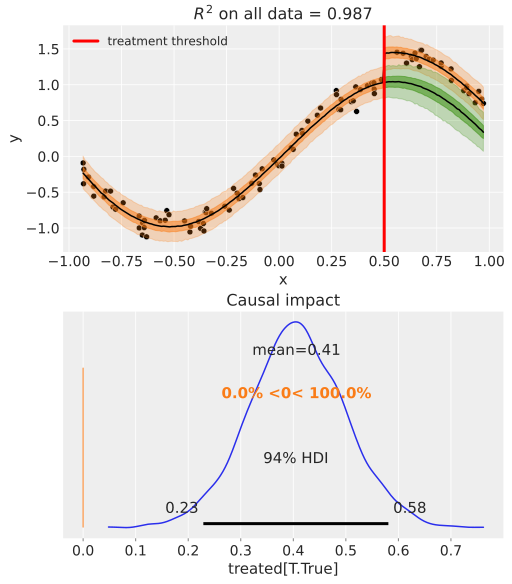

In [15]:
from causalpy.pymc_experiments import RegressionDiscontinuity
from causalpy.pymc_models import LinearRegression

thing = RegressionDiscontinuity(data, 
                                formula = 'y ~ 1 + bs(x, df=6) + treated',
                                prediction_model=LinearRegression(), 
                                treatment_threshold=0.5)
thing.plot()

if export_images:
    plt.savefig('../img/regression_discontinuity_pymc.svg', bbox_inches='tight', format="svg")